## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler, power_transform
from sklearn import tree
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Importing files to pandas

In [2]:
train=pd.read_csv('train.csv')

In [3]:
train.head(4)

,Severity,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Accident_Type_Code,Max_Elevation,Violations,Adverse_Weather_Metric,Accident_ID
0,Minor_Damage_And_Injuries,49.223744,14,22,71.285324,0.272118,78.04,2,31335.476824,3,0.424352,7570
1,Minor_Damage_And_Injuries,62.465753,10,27,72.288058,0.423939,84.54,2,26024.711057,2,0.352350,12128
2,Significant_Damage_And_Fatalities,63.059361,13,16,66.362808,0.322604,78.86,7,39269.053927,3,0.003364,2181
3,Significant_Damage_And_Serious_Injuries,48.082192,11,9,74.703737,0.337029,81.79,3,42771.499200,1,0.211728,5946


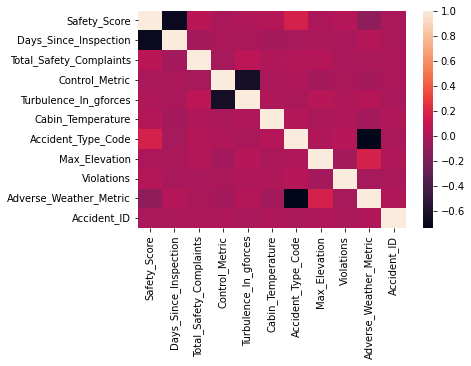

In [4]:
sns.heatmap(train.corr());

In [8]:
train.skew()

Safety_Score               0.236302
Days_Since_Inspection     -0.073910
Total_Safety_Complaints    1.888080
Control_Metric            -0.201482
Turbulence_In_gforces      0.816746
Cabin_Temperature          0.854437
Accident_Type_Code         0.252367
Max_Elevation             -0.038195
Violations                 0.096772
Adverse_Weather_Metric     2.074086
Accident_ID               -0.006091
dtype: float64

# Data Processing and Feature Engineering

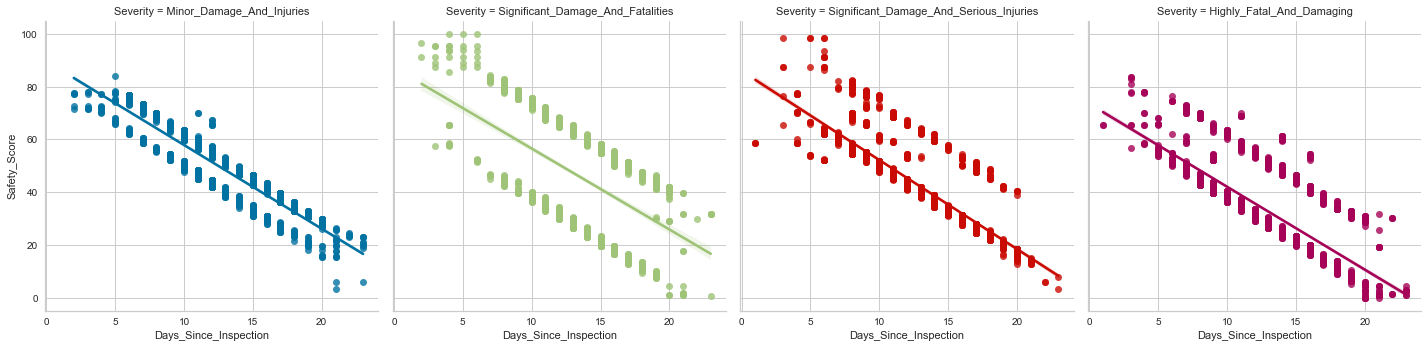

In [48]:
sns.lmplot(x='Days_Since_Inspection',y='Safety_Score',col='Severity',hue='Severity',data=train);

The severity class is well identified from the graph, Its shows the pattern for all the four classes,
and the 'Days Since Inspection' Feature was Well explained by the Graph w.r.t to the 'Safety Score'.

In [4]:
train = train.replace({'Severity': 
                            {"Highly_Fatal_And_Damaging": 0,
                            "Significant_Damage_And_Serious_Injuries": 1,
                            "Minor_Damage_And_Injuries": 2,
                            "Significant_Damage_And_Fatalities": 3, }
                            })

In [5]:
x=train[['Safety_Score','Days_Since_Inspection','Control_Metric','Adverse_Weather_Metric']]
y=train[['Severity']]

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

# Under Sampeling
For Balancing the data for all the different classes

In [7]:
sm = SMOTE(random_state=2)
x_train_res, y_train_res = sm.fit_resample(x_train,y_train)

In [8]:
print(f"After ReSampelling: \n{y_train_res.value_counts()}")

After ReSampelling: 
Severity
0           2047
1           2047
2           2047
3           2047
dtype: int64


# Hyperparameter Tuning

In [11]:
max_depth=[4,5,6,7,8]
learning_rate=[0.06,0.07,0.08,0.09,0.04]
estimators=[75,100,200,250,270,350,450,600]
max_features=[1.0,0.5,0.2,0.6,0.8]
max_samples=[1.0,0.5,0.75,0.25,0.43]
baseestimator=[None]
param=dict(n_estimators=estimators,base_estimator=baseestimator,max_features=max_features,max_samples=max_samples)
cvFolds=5
scoring='accuracy'

In [13]:
from sklearn.model_selection import GridSearchCV
grid=GridSearchCV(estimator=BaggingClassifier(),param_grid=param,cv=cvFolds,n_jobs=-1,scoring=scoring)
grid.fit(x_train_res,y_train_res) 

GridSearchCV(cv=5, estimator=BaggingClassifier(), n_jobs=-1,
             param_grid={'base_estimator': [None],
                         'max_features': [1.0, 0.5, 0.2, 0.6, 0.8],
                         'max_samples': [1.0, 0.5, 0.75, 0.25, 0.43],
                         'n_estimators': [75, 100, 200, 250, 270, 350, 450,
                                          600]},
             scoring='accuracy')

In [14]:
 print(f"The Best Parameters So far, {grid.best_params_}")

The Best Parameters So far, {'base_estimator': None, 'max_features': 1.0, 'max_samples': 0.75, 'n_estimators': 200}


In [15]:
print(f"The Best Score So far, {grid.best_score_}")

The Best Score So far, 0.9621397878575643


# Model Selection

In [9]:
bagging = BaggingClassifier(base_estimator= None,
 max_features= 1.0,
 max_samples= 0.75,
 n_estimators= 200
           )

In [10]:
bagging.fit(x_train_res,y_train_res)

BaggingClassifier(max_samples=0.75, n_estimators=200)

In [11]:
predictions=bagging.predict(x_test)

# Plotting Metrics

In [14]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

With UnSeen Test dataset

In [15]:
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95      1002
           1       0.95      0.95      0.95       933
           2       0.93      0.96      0.95       825
           3       0.94      0.95      0.94       540

    accuracy                           0.95      3300
   macro avg       0.95      0.95      0.95      3300
weighted avg       0.95      0.95      0.95      3300

[[934  29  18  21]
 [ 17 885  24   7]
 [ 18   9 793   5]
 [  4   9  16 511]]


With Already Trained Test data set

In [16]:
predictions=bagging.predict(x_train)

In [17]:
print(classification_report(y_train,predictions))
print(confusion_matrix(y_train,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2047
           1       1.00      1.00      1.00      1796
           2       1.00      1.00      1.00      1702
           3       1.00      1.00      1.00      1155

    accuracy                           1.00      6700
   macro avg       1.00      1.00      1.00      6700
weighted avg       1.00      1.00      1.00      6700

[[2044    0    0    3]
 [   0 1793    2    1]
 [   1    0 1700    1]
 [   0    0    1 1154]]


"Yellow Brick" is a famous library for plotting learning Curves

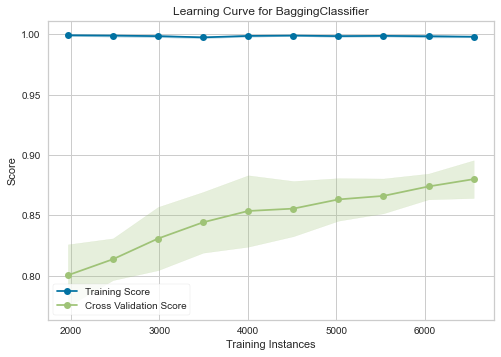

<AxesSubplot:title={'center':'Learning Curve for BaggingClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [32]:
from yellowbrick.model_selection import LearningCurve
train=np.linspace(0.3,1,10)
r2='accuracy'
lc=LearningCurve(bagging,train_sizes=train,scoring='r2',n_jobs=-1)
lc.fit(x_train_res,y_train_res)
lc.poof()

Model can be trained more if i get more training examples and it is also the time for the challege is over

# Exporting Model for web

So Finally I build the model Which is Ok in terms of competitions prespective, actually it is 5 % overfitting, but the learning curve seems to be increasing, 

I got a well generalized model with 86 % percent accuracy, but the overfit model performs well in competition, so i deploy that model.

In [1]:
import pickle

In [19]:
pickle.dump(bagging,open('model.pkl','wb'))

In [17]:
model=pickle.load(open('model.pkl','rb'))